In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline

In [3]:
df = pd.read_csv('data.csv')
close = df["Close"]
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date",inplace=True)
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2010-09-13,15400,15519,15320,15400,234851
2010-09-14,15500,15620,15200,15200,371530
2010-09-15,15260,15340,15020,15140,389289
2010-09-16,15080,15260,15080,15140,234815
2010-09-17,15240,15560,15159,15460,447649


In [4]:
df2 = df.drop(["Open","High","Low","Volume"],axis=1)
df2.head()

,Close
Date,
2010-09-13,15400
2010-09-14,15200
2010-09-15,15140
2010-09-16,15140
2010-09-17,15460


## Converting the dataframe to only Date and Close

In [5]:
print(df2.index)
df2.describe()

DatetimeIndex(['2010-09-13', '2010-09-14', '2010-09-15', '2010-09-16',
               '2010-09-17', '2010-09-20', '2010-09-24', '2010-09-27',
               '2010-09-28', '2010-09-29',
               ...
               '2017-03-30', '2017-03-31', '2017-04-03', '2017-04-04',
               '2017-04-05', '2017-04-06', '2017-04-07', '2017-04-10',
               '2017-04-11', '2017-04-12'],
              dtype='datetime64[ns]', name='Date', length=1628, freq=None)


,Close
count,1628.000000
mean,25564.656020
std,5436.660567
min,13600.000000
25%,22700.000000
50%,25900.000000
75%,28545.000000
max,42560.000000


## Plotting the stock price and natural log of stock price

AxesSubplot(0.125,0.2;0.775x0.68)
AxesSubplot(0.125,0.2;0.775x0.68)


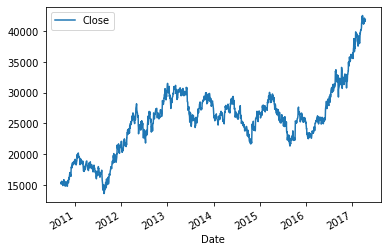

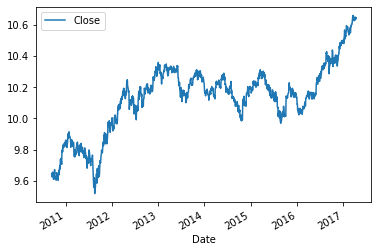

In [7]:
print(df2.plot())
log_df2 = np.log(df2)
print(log_df2.plot());

In [8]:
stockprice = pd.Series(df2["Close"])
logprice = pd.Series(log_df2["Close"])
print(type(stockprice),type(logprice))

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


### The following cells were used to get an idea of acf, pacf, autocorrelation using pandas. (These results were not used in the model.)

c:\program files\python39\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
c:\program files\python39\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


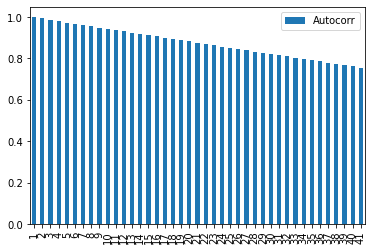

In [9]:
acf_stockprice = acf(stockprice)[0:100]
acf1 = pd.DataFrame(acf_stockprice)
acf1.columns = ["Autocorr"]
acf1.index += 1
acf1.plot(kind='bar')
plt.show()

c:\program files\python39\lib\site-packages\statsmodels\tsa\stattools.py:1024: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


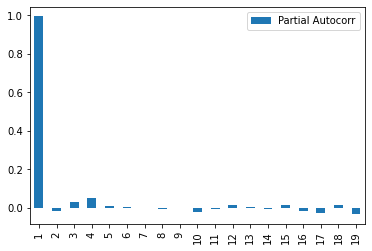

In [10]:
pacf_stockprice = pacf(stockprice)[1:20]
pacf1 = pd.DataFrame(pacf_stockprice)
pacf1.columns = ["Partial Autocorr"]
pacf1.index += 1
pacf1.plot(kind='bar')
plt.show()

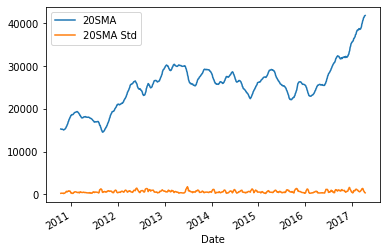

In [11]:
stockprice.rolling(20).mean().plot(label="20SMA")
stockprice.rolling(20).std().plot(label="20SMA Std")
#stockprice.plot()
plt.legend()

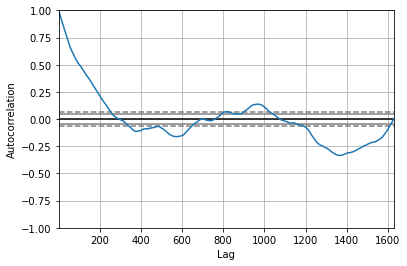

In [12]:
autocorr_stockprice = pd.plotting.autocorrelation_plot(stockprice)


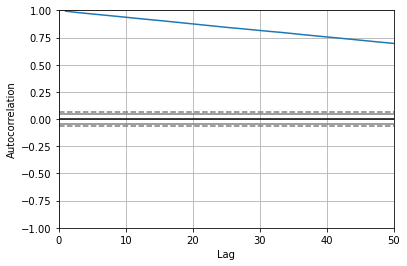

In [12]:
autocorr_stockprice = pd.plotting.autocorrelation_plot(stockprice)
autocorr_stockprice.set_xlim([0,50])
plt.show()

### ADF Test used to find the stationarity of the dataset. 

Here, the data is non-stationary since the p-value exceeds 0.5

In [13]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(stockprice.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -0.4691553936793729
p-value: 0.8978963725565923


### Using the ACF to estimate the differencing needed in the dataset

In [14]:
from statsmodels.graphics.tsaplots import plot_acf

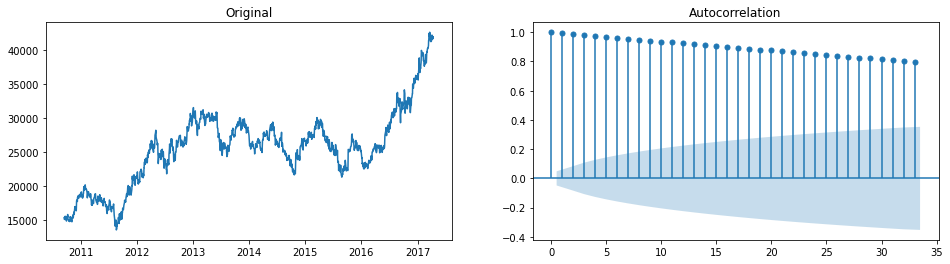

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(df2)
ax1.set_title("Original")
# add ; at the end of the plot function so that the plot is not duplicated
plot_acf(df2, ax=ax2);

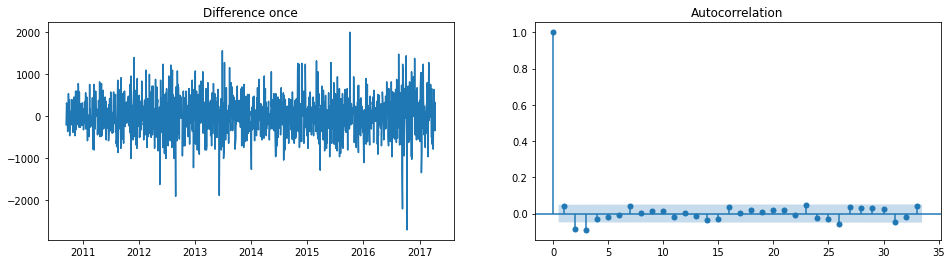

In [16]:
diff = df2.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
plot_acf(diff, ax=ax2);

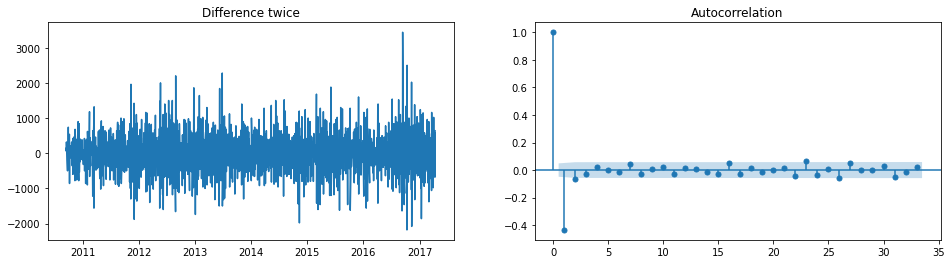

In [17]:
diff = df2.diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference twice")
plot_acf(diff, ax=ax2);

### Using pmdarima ndiffs to calculate differencing needed

In [18]:
from pmdarima.arima.utils import ndiffs
ndiffs(stockprice, test="adf")

1

### Finding p (AR term in ARIMA) using PACF 

We can choose p as 1 for our sample test since it is close to the significance line

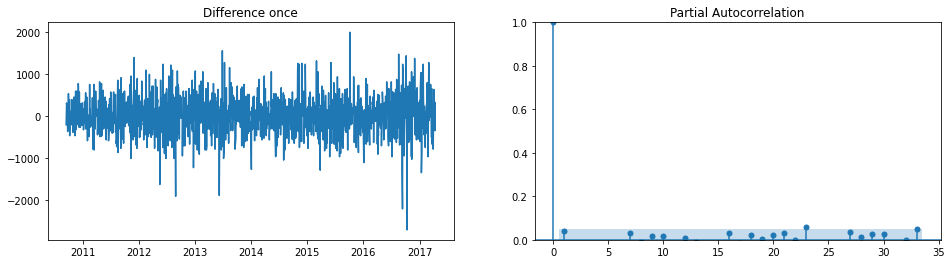

In [19]:
from statsmodels.graphics.tsaplots import plot_pacf
diff = df2.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_pacf(diff, ax=ax2);

### Finding q (MA term) using ACF

We can choose q as 1 for our sample test since it is close to the significance line.

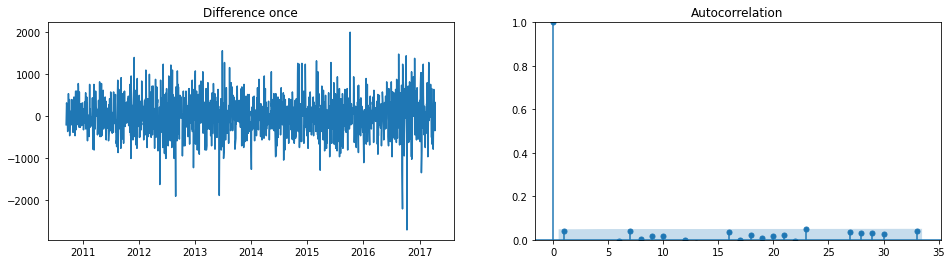

In [20]:
diff = df2.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_acf(diff, ax=ax2);

### Using the ARIMA Model

Although the model input here is (2,1,1), I tested out the (1,1,1) model and this one was slightly better. The values (2,1,1) were obtained from auto_arima in pmdarima which is referenced at the bottom of the Notebook

In [77]:
from statsmodels.tsa.arima_model import ARIMA

# ARIMA Model
model = ARIMA(df2, order=(2, 1, 1))
result = model.fit(disp=0)

c:\program files\python39\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\program files\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequen

In [78]:
print(result.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1627
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -12178.839
Method:                       css-mle   S.D. of innovations            431.171
Date:                Sun, 03 Oct 2021   AIC                          24367.678
Time:                        08:26:38   BIC                          24394.651
Sample:                             1   HQIC                         24377.685
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            16.3145      8.669      1.882      0.060      -0.676      33.305
ar.L1.D.Close     0.6448      0.103      6.254      0.000       0.443       0.847
ar.L2.D.Close    -0.1236      0.025     

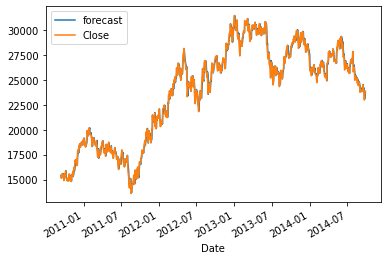

In [88]:
# Actual vs Fitted
result.plot_predict(
    start=1,
    end=1000,
    dynamic=False,
);

#### From my own viewing of the ACF and PACF plots, I decided to try out (7,1,7) which actually turned out to provide slightly smaller errors than (2,1,1) and (1,1,1)

In [29]:
step = 1086

model = ARIMA(df2, order=(7, 1, 7))
result = model.fit(disp=0)

# Forecast
fc, se, conf = result.forecast(step)

c:\program files\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\program files\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\program files\python39\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
c:\program files\python39\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood opti

In [30]:
for i in fc:
    print(float(i))

41917.471920040596
41979.443682942314
41944.85834137617
41883.25627378524
42024.53375220169
42011.345239743794
41919.55769217227
41918.34165678457
41841.57746256924
41898.45828537703
42111.60418795789
42127.3236508786
42116.65793666948
42121.57859720581
42025.47966772728
42098.01620848781
42206.657560251566
42127.18970124774
42111.47599925631
42098.56596561319
42071.01317087104
42244.82810533604
42341.8358135399
42275.46841928889
42276.9243861779
42218.890827292875
42205.99110421847
42358.58386318295
42363.18430631581
42296.34627008374
42314.77934491205
42277.19940197178
42356.516395387094
42517.13502630929
42476.33744164962
42424.21569728573
42416.233984049635
42367.55397799884
42477.94448011907
42581.770213254196
42507.22889871331
42492.761398411065
42491.38748296823
42494.110757586706
42646.463626840035
42690.539636619964
42597.763484190466
42590.118755385214
42565.697611803575
42603.64822975091
42753.19260025868
42739.13076384753
42667.314070103435
42682.761549142684
42670.48644996

### Auto ARIMA from pmd_arima which can automatically compute suitable values for the ARIMA model. 

Oddly, the tests did not run beyond p=3 or q=2 even though I set the bounds as p=10, q=10. The auto_arima searches for the minimum AIC value when outputting an ARIMA model.

In [73]:
from pmdarima.arima import auto_arima

In [76]:
model = auto_arima(
    df2,
    start_p=1,
    start_q=1,
    test="adf",
    max_p=10,
    max_q=10,
    m=1,  # frequency of series
    d=None,  # determine 'd'
    seasonal=False,  # no seasonality
    trace=True,
    stepwise=True,
)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=24386.516, Time=1.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=24390.269, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=24390.072, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=24389.640, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=24390.549, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=24368.388, Time=1.55 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=24379.311, Time=0.35 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=24370.041, Time=1.32 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=24368.911, Time=2.76 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=24370.108, Time=1.73 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=24369.957, Time=0.47 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=24371.688, Time=2.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=24369.958, Time=0.63 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 13.014 seconds


### (2,1,1) and (1,1,1) model

In [23]:
step = 1086

model = ARIMA(df2, order=(2, 1, 1))
result = model.fit(disp=0)

# Forecast
fc, se, conf = result.forecast(step)

c:\program files\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\program files\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [25]:
for i in fc:
    print(i)

41954.12618789574
41959.74407675142
41964.486163583504
41974.66149518708
41988.448411915124
42003.89222777005
42019.95782809594
42036.21947574133
42052.53065007572
42068.84951780214
42085.167222265896
42101.48322539904
42117.79827536874
42134.11292111561
42150.42742408094
42166.741884963696
42183.05633636674
42199.37078686079
42215.68523794088
42231.99968951124
42248.31414132526
42264.628593235764
42280.943045178356
42297.2574971297
42313.571949082725
42329.88640103575
42346.20085298857
42362.515304941255
42378.82975689388
42395.14420884648
42411.45866079908
42427.773112751674
42444.08756470426
42460.40201665686
42476.716468609455
42493.03092056205
42509.34537251465
42525.65982446724
42541.97427641984
42558.288728372434
42574.60318032503
42590.917632277626
42607.23208423022
42623.54653618282
42639.86098813541
42656.17544008801
42672.489892040605
42688.8043439932
42705.1187959458
42721.43324789839
42737.74769985099
42754.062151803584
42770.37660375618
42786.691055708776
42803.0055076613

In [26]:
step = 1086

model = ARIMA(df2, order=(1, 1, 1))
result = model.fit(disp=0)

# Forecast
fc, se, conf = result.forecast(step)

c:\program files\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\program files\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [27]:
for i in fc:
    print(i)

41912.86627636541
41926.476256452246
41940.66920707389
41955.31913355118
41970.32727184223
41985.61620331291
42001.12524145426
42016.806815647025
42032.623636486096
42048.54647375005
42064.55241460773
42080.623498270375
42096.74564573001
42112.9078208084
42129.10137252463
42145.31951959356
42161.556946337325
42177.80948593049
42194.073872104025
42210.34754451224
42226.628496164914
42242.91515383319
42259.20628430277
42275.50092088813
42291.798305828976
42308.09784513616
42324.399073196626
42340.701625028065
42357.00521453009
42373.30961743583
42389.61465794817
42405.920198264204
42422.226130363706
42438.53236957236
42454.8388495161
42471.14551816599
42487.45233473786
42503.75926726203
42520.06629067827
42536.3733853425
42552.680535856234
42568.98773014898
42585.29495875899
42601.602214269435
42617.90949086644
42634.21678399268
42650.524090075756
42666.83140631538
42683.13873051646
42699.446060958326
42715.75339629218
42732.06073546074
42748.36807763524
42764.67542216601
42780.982768543

58240.35346109605
58256.660814172894
58272.96816724974
58289.275520326584
58305.58287340343
58321.890226480275
58338.19757955712
58354.504932633965
58370.81228571081
58387.119638787655
58403.4269918645
58419.734344941346
58436.04169801819
58452.349051095036
58468.65640417188
58484.963757248726
58501.27111032557
58517.57846340242
58533.88581647926
58550.19316955611
58566.50052263295
58582.8078757098
58599.11522878664
58615.42258186349
58631.72993494033
58648.03728801718
58664.34464109402
58680.65199417087
58696.95934724771
58713.26670032456
58729.574053401404
58745.88140647825
58762.188759555094
58778.49611263194
58794.803465708785
58811.11081878563
58827.418171862475
58843.72552493932
58860.032878016165
58876.34023109301
58892.647584169856
58908.9549372467
58925.262290323546
58941.56964340039
58957.87699647724
58974.18434955408
58990.49170263093
59006.79905570777
59023.10640878462
59039.41376186146
59055.72111493831
59072.02846801515
59088.335821092
59104.64317416884
59120.95052724569


Credit to 
1. https://www.youtube.com/watch?v=BDavl5caJnI
2. https://www.youtube.com/watch?v=gqryqIlvEoM

which acted as very helpful guides in this project.
